In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/pgdatafinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: TEMP
Index: 1, Column Name: RHUM
Index: 2, Column Name: WDSP
Index: 3, Column Name: MAXT
Index: 4, Column Name: MINT


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/ry2018.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TEMP     365 non-null    float64
 1   MAXTEMP  365 non-null    float64
 2   MINTEMP  365 non-null    float64
 3   DEWP     365 non-null    float64
 4   HUM      365 non-null    float64
 5   WS       365 non-null    float64
 6   MAXWS    365 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


In [4]:
df_train = df["2002-01-01":"2015-12-31"]
df_valid = df["2016-01-01":"2017-12-31"]
df_test = df["2018-01-01":"2018-12-31"]

In [5]:
import tensorflow as tf

def split_inputs_and_targets(time_series, ahead=365, target_cols=0):
	return time_series[:, :-ahead], time_series[:, -ahead:, target_cols]

seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

2025-03-11 23:57:11.150706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 23:57:11.181892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 23:57:14.371167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-11 23:57:14.376418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devi

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

Y_ref = ry.iloc[:, 0].to_numpy()
Y_test = df_test.iloc[:, 0].to_numpy()

mae_ref = mean_absolute_error(Y_test, Y_ref)
print(f'Mean Absolute Error (MAE): {mae_ref}')

rmse_ref = np.sqrt(mean_squared_error(Y_test, Y_ref))
print(f'Root Mean Squared Error (RMSE): {rmse_ref}')

X = df_valid.to_numpy()[np.newaxis, :seq_length]

Mean Absolute Error (MAE): 3.398904109589041
Root Mean Squared Error (RMSE): 4.313210036842376


In [7]:
conv_lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365)
])

conv_lstm_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_32 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=100)
conv_lstm_32.save('models/conv_lstm_32.keras')  

Epoch 1/100


2025-03-09 01:54:17.262440: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 322.0818 - mae: 15.8432 - val_loss: 239.2819 - val_mae: 13.0638
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 188.4992 - mae: 11.3284 - val_loss: 156.5168 - val_mae: 10.1450
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 123.0608 - mae: 8.9241 - val_loss: 114.8167 - val_mae: 8.6345
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 91.5608 - mae: 7.8209 - val_loss: 95.0971 - val_mae: 7.9483
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 78.0289 - mae: 7.3683 - val_loss: 87.0104 - val_mae: 7.7110
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 72.8716 - mae: 7.2155 - val_loss: 83.9230 - val_mae: 7.6217
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 71.3924 - mae: 7.1853 - val_loss: 82.7843 - val_mae: 7.5890
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.9257 - mae: 7.1777 - val_loss: 82.5352 - val_mae: 7.5841
Epoch 9/100
137/137 ━━━━━━

In [8]:
conv_lstm_32 = tf.keras.models.load_model('models/conv_lstm_32.keras')
Y_conv_lstm_32 = conv_lstm_32.predict(X)
Y_conv_lstm_32 = Y_conv_lstm_32.flatten()

mae_conv_lstm_32 = mean_absolute_error(Y_test, Y_conv_lstm_32)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_32}')

rmse_conv_lstm_32 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_32))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_32}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Mean Absolute Error (MAE): 2.516155998282237
Root Mean Squared Error (RMSE): 3.114375203819363


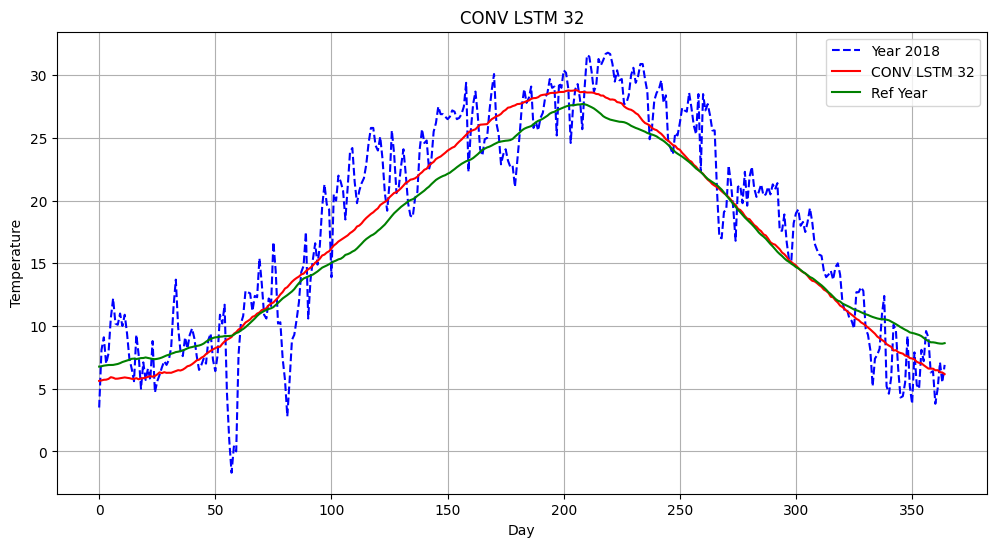

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_32, label="CONV LSTM 32", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365)
])

conv_lstm_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_64 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=80)
conv_lstm_64.save('models/conv_lstm_64.keras')  

Epoch 1/80


2025-03-09 02:28:18.496893: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 291.5746 - mae: 14.8283 - val_loss: 160.2685 - val_mae: 10.2680
Epoch 2/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 116.6586 - mae: 8.7003 - val_loss: 96.3831 - val_mae: 8.0063
Epoch 3/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 76.9250 - mae: 7.3362 - val_loss: 84.8021 - val_mae: 7.6612
Epoch 4/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 71.3403 - mae: 7.1842 - val_loss: 82.7696 - val_mae: 7.5943
Epoch 5/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 70.9399 - mae: 7.1846 - val_loss: 82.8349 - val_mae: 7.6030
Epoch 6/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 70.8086 - mae: 7.1813 - val_loss: 82.9036 - val_mae: 7.6072
Epoch 7/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.8996 - mae: 7.1875 - val_loss: 82.8008 - val_mae: 7.6024
Epoch 8/80
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 70.8387 - mae: 7.1838 - val_loss: 83.1594 - val_mae: 7.6209
Epoch 9/80
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
conv_lstm_64 = tf.keras.models.load_model('models/conv_lstm_64.keras')
Y_conv_lstm_64 = conv_lstm_64.predict(X)
Y_conv_lstm_64 = Y_conv_lstm_64.flatten()

mae_conv_lstm_64 = mean_absolute_error(Y_test, Y_conv_lstm_64)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_64}')

rmse_conv_lstm_64 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_64))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_64}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Mean Absolute Error (MAE): 2.5938078211431637
Root Mean Squared Error (RMSE): 3.261711734572352


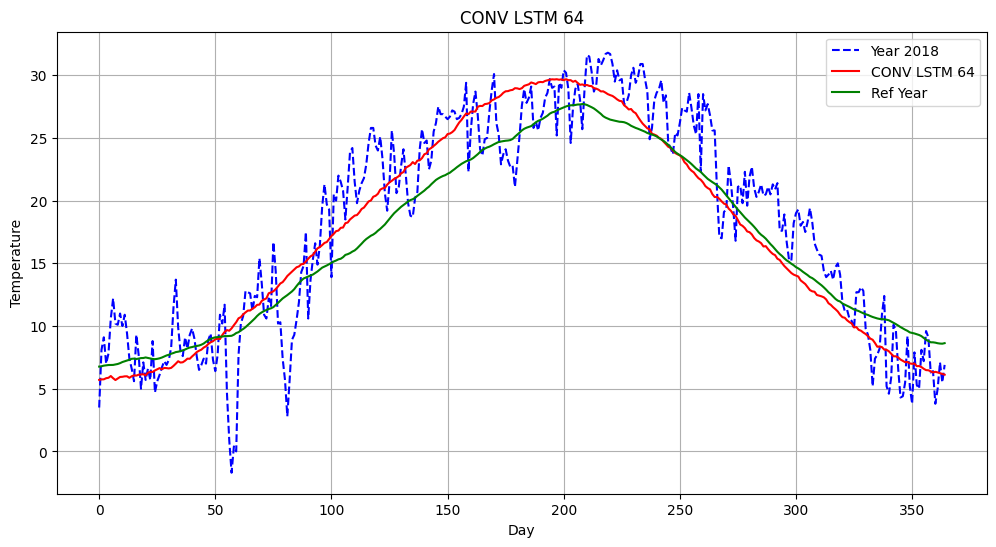

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_64, label="CONV LSTM 64", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365)
])

conv_lstm_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_128.save('models/conv_lstm_128.keras')  

Epoch 1/50


2025-03-09 02:49:35.616252: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 247.6232 - mae: 13.3046 - val_loss: 95.0783 - val_mae: 7.9795
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 74.2159 - mae: 7.2516 - val_loss: 79.9123 - val_mae: 7.4553
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 68.9290 - mae: 7.0788 - val_loss: 79.1361 - val_mae: 7.4187
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 67.7227 - mae: 7.0127 - val_loss: 76.9748 - val_mae: 7.3086
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 66.6497 - mae: 6.9524 - val_loss: 75.7792 - val_mae: 7.2293
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 64.8633 - mae: 6.8497 - val_loss: 72.3347 - val_mae: 7.0468
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 62.6962 - mae: 6.7265 - val_loss: 68.0952 - val_mae: 6.8177
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 60.3580 - mae: 6.5876 - val_loss: 64.6236 - val_mae: 6.6278
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 2

In [8]:
conv_lstm_128 = tf.keras.models.load_model('models/conv_lstm_128.keras')
Y_conv_lstm_128 = conv_lstm_128.predict(X)
Y_conv_lstm_128 = Y_conv_lstm_128.flatten()

mae_conv_lstm_128 = mean_absolute_error(Y_test, Y_conv_lstm_128)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128}')

rmse_conv_lstm_128 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_128))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Mean Absolute Error (MAE): 2.516360856670223
Root Mean Squared Error (RMSE): 3.141730183493255


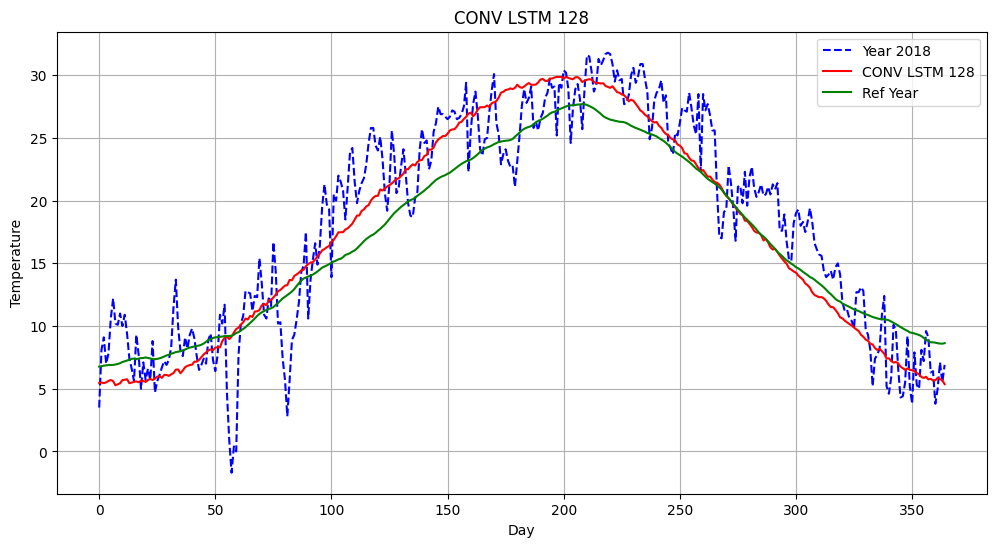

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_128, label="CONV LSTM 128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365)
])

conv_lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_3232 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=75)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/75


2025-03-09 23:22:25.373418: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 321.1151 - mae: 15.8126 - val_loss: 240.0969 - val_mae: 13.0694
Epoch 2/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 189.1543 - mae: 11.3521 - val_loss: 158.0532 - val_mae: 10.1988
Epoch 3/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 123.6531 - mae: 8.9457 - val_loss: 116.0504 - val_mae: 8.6687
Epoch 4/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 91.9009 - mae: 7.8328 - val_loss: 95.9842 - val_mae: 7.9775
Epoch 5/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 78.1885 - mae: 7.3735 - val_loss: 87.5963 - val_mae: 7.7299
Epoch 6/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 72.9377 - mae: 7.2175 - val_loss: 84.2798 - val_mae: 7.6347
Epoch 7/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 71.4148 - mae: 7.1859 - val_loss: 82.9842 - val_mae: 7.5957
Epoch 8/75
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9312 - mae: 7.1778 - val_loss: 82.6353 - val_mae: 7.5875
Epoch 9/75
137/137 ━━━━━━━━━━━━━━

In [8]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')
Y_conv_lstm_3232 = conv_lstm_3232.predict(X)
Y_conv_lstm_3232 = Y_conv_lstm_3232.flatten()

mae_conv_lstm_3232 = mean_absolute_error(Y_test, Y_conv_lstm_3232)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_3232}')

rmse_conv_lstm_3232 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Mean Absolute Error (MAE): 2.630913810991261
Root Mean Squared Error (RMSE): 3.2184705191221443


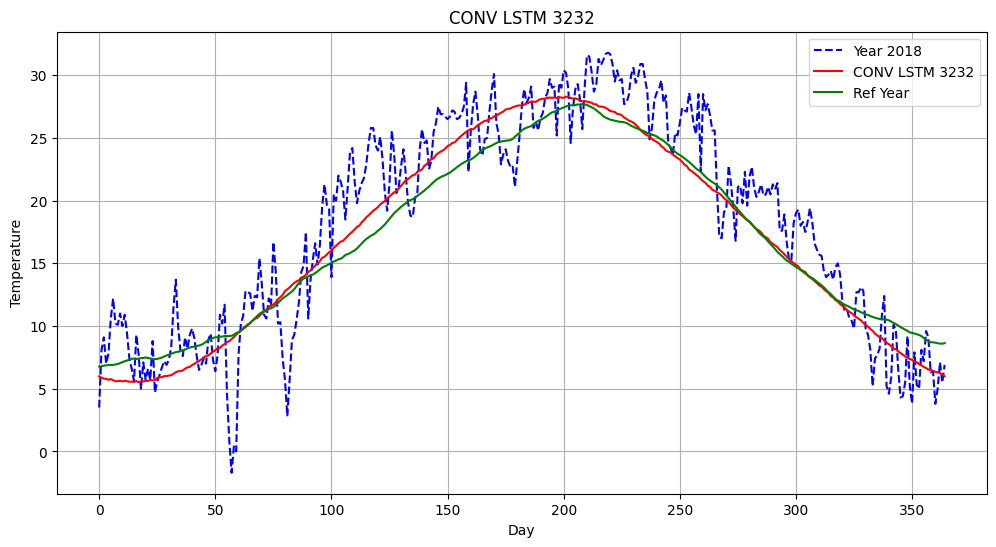

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_3232, label="CONV LSTM 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365)
])

conv_lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_6464 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=70)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/70


2025-03-10 21:09:44.708552: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 288.2522 - mae: 14.7189 - val_loss: 159.0533 - val_mae: 10.2275
Epoch 2/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 115.5672 - mae: 8.6616 - val_loss: 96.4616 - val_mae: 8.0067
Epoch 3/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 76.7124 - mae: 7.3301 - val_loss: 84.9854 - val_mae: 7.6736
Epoch 4/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 71.3168 - mae: 7.1838 - val_loss: 82.8502 - val_mae: 7.5992
Epoch 5/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.9392 - mae: 7.1848 - val_loss: 82.8596 - val_mae: 7.6043
Epoch 6/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8090 - mae: 7.1813 - val_loss: 82.9129 - val_mae: 7.6076
Epoch 7/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8998 - mae: 7.1875 - val_loss: 82.8081 - val_mae: 7.6028
Epoch 8/70
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8389 - mae: 7.1838 - val_loss: 83.1708 - val_mae: 7.6216
Epoch 9/70
137/137 ━━━━━━━━━━━━━━━━━━━

In [11]:
conv_lstm_6464 = tf.keras.models.load_model('models/conv_lstm_6464.keras')
Y_conv_lstm_6464 = conv_lstm_6464.predict(X)
Y_conv_lstm_6464 = Y_conv_lstm_6464.flatten()

mae_conv_lstm_6464 = mean_absolute_error(Y_test, Y_conv_lstm_6464)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_6464}')

rmse_conv_lstm_6464 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Mean Absolute Error (MAE): 2.722399563985328
Root Mean Squared Error (RMSE): 3.353307906411171


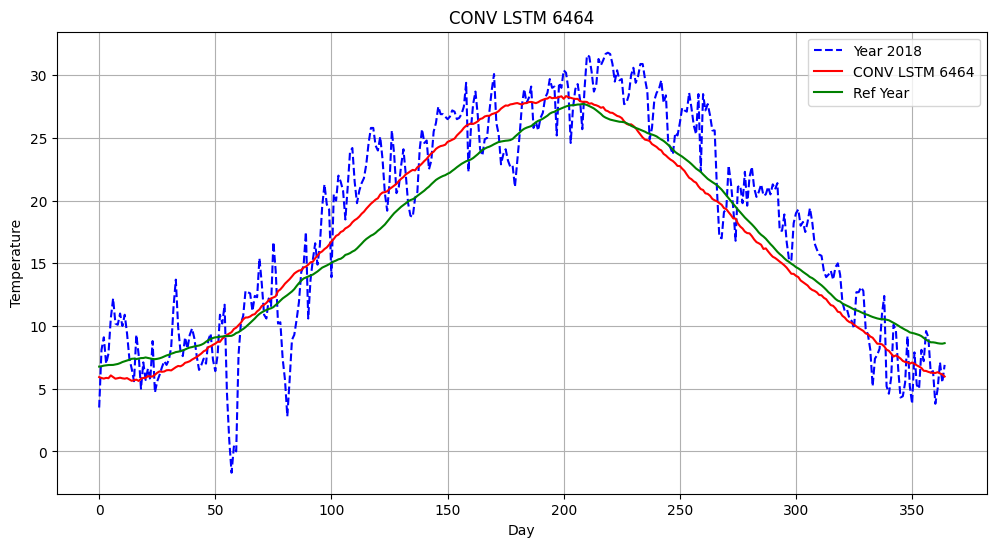

In [12]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_6464, label="CONV LSTM 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365)
])

conv_lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_128128 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/50


2025-03-10 21:25:45.362772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 243.7998 - mae: 13.1731 - val_loss: 95.4402 - val_mae: 8.0094
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 74.3629 - mae: 7.2662 - val_loss: 83.5066 - val_mae: 7.6357
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.8932 - mae: 7.1862 - val_loss: 84.4129 - val_mae: 7.6823
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.9126 - mae: 7.1870 - val_loss: 83.9216 - val_mae: 7.6587
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 70.9639 - mae: 7.1896 - val_loss: 84.4296 - val_mae: 7.6838
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.8606 - mae: 7.1842 - val_loss: 84.3616 - val_mae: 7.6805
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.9430 - mae: 7.1894 - val_loss: 84.0887 - val_mae: 7.6673
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 70.8742 - mae: 7.1851 - val_loss: 85.3337 - val_mae: 7.7305
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 3

In [8]:
conv_lstm_128128 = tf.keras.models.load_model('models/conv_lstm_128128.keras')
Y_conv_lstm_128128 = conv_lstm_128128.predict(X)
Y_conv_lstm_128128 = Y_conv_lstm_128128.flatten()

mae_conv_lstm_128128 = mean_absolute_error(Y_test, Y_conv_lstm_128128)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128128}')

rmse_conv_lstm_128128 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Mean Absolute Error (MAE): 2.5128588070281563
Root Mean Squared Error (RMSE): 3.0890610525253805


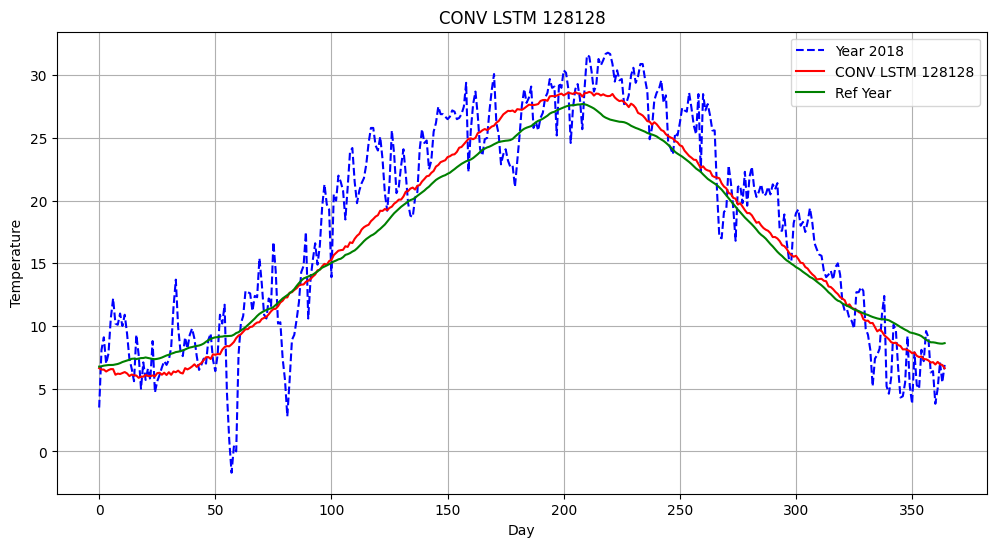

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_128128, label="CONV LSTM 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

conv_gru_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_32 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=100)
conv_gru_32.save('models/conv_gru_32.keras')  

Epoch 1/100


2025-03-10 21:55:45.214669: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 319.0213 - mae: 15.7545 - val_loss: 253.8170 - val_mae: 13.5186
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 202.6418 - mae: 11.8427 - val_loss: 171.3422 - val_mae: 10.6897
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 134.9947 - mae: 9.3571 - val_loss: 125.0085 - val_mae: 8.9922
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 98.9366 - mae: 8.0751 - val_loss: 101.0204 - val_mae: 8.1313
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 81.7559 - mae: 7.4888 - val_loss: 90.0318 - val_mae: 7.8047
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 74.4376 - mae: 7.2587 - val_loss: 85.3311 - val_mae: 7.6616
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 71.9404 - mae: 7.1965 - val_loss: 83.4077 - val_mae: 7.6083
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 71.0817 - mae: 7.1783 - val_loss: 82.7806 - val_mae: 7.5916
Epoch 9/100
137/137 ━━━━━

In [8]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')
Y_conv_gru_32 = conv_gru_32.predict(X)
Y_conv_gru_32 = Y_conv_gru_32.flatten()

mae_conv_gru_32 = mean_absolute_error(Y_test, Y_conv_gru_32)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_32}')

rmse_conv_gru_32 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_32))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_32}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Mean Absolute Error (MAE): 2.311140674173015
Root Mean Squared Error (RMSE): 2.9267391055111176


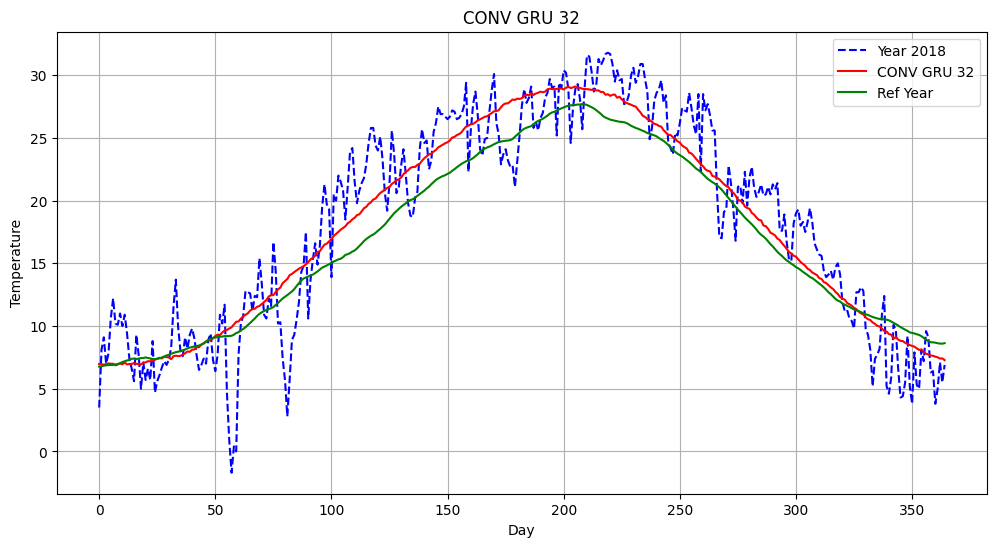

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_32, label="CONV GRU 32", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

conv_gru_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_64 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_gru_64.save('models/conv_gru_64.keras')  

Epoch 1/60


2025-03-10 22:39:01.482359: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 290.6363 - mae: 14.8100 - val_loss: 170.2329 - val_mae: 10.6512
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 125.2276 - mae: 9.0074 - val_loss: 100.3321 - val_mae: 8.0918
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 79.6133 - mae: 7.4213 - val_loss: 85.5003 - val_mae: 7.6679
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 71.7385 - mae: 7.1915 - val_loss: 82.8169 - val_mae: 7.5911
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 70.9680 - mae: 7.1833 - val_loss: 82.7663 - val_mae: 7.5986
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.8063 - mae: 7.1806 - val_loss: 82.8136 - val_mae: 7.6026
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.8965 - mae: 7.1872 - val_loss: 82.7173 - val_mae: 7.5982
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 70.8364 - mae: 7.1837 - val_loss: 83.0455 - val_mae: 7.6153
Epoch 9/60
137/137 ━━━━━━━━━━━━━━━━━━

In [8]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')
Y_conv_gru_64 = conv_gru_64.predict(X)
Y_conv_gru_64 = Y_conv_gru_64.flatten()

mae_conv_gru_64 = mean_absolute_error(Y_test, Y_conv_gru_64)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_64}')

rmse_conv_gru_64 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_64))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_64}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Mean Absolute Error (MAE): 2.943593968691891
Root Mean Squared Error (RMSE): 3.7232669572355928


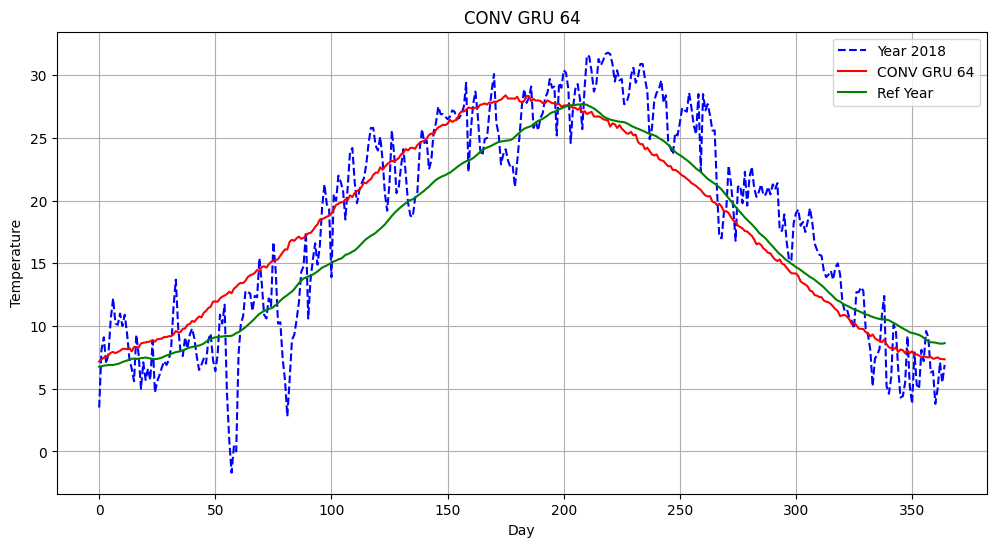

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_64, label="CONV GRU 64", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

conv_gru_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128.save('models/conv_gru_128.keras')  

Epoch 1/30


2025-03-10 22:54:28.832912: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 244.8663 - mae: 13.2252 - val_loss: 98.4777 - val_mae: 8.0580
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 76.3453 - mae: 7.3243 - val_loss: 83.3014 - val_mae: 7.6195
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 70.8983 - mae: 7.1845 - val_loss: 84.1397 - val_mae: 7.6685
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 70.9075 - mae: 7.1867 - val_loss: 83.6844 - val_mae: 7.6465
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 70.9574 - mae: 7.1893 - val_loss: 84.2029 - val_mae: 7.6726
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 70.8491 - mae: 7.1836 - val_loss: 83.6623 - val_mae: 7.6405
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 70.2284 - mae: 7.1497 - val_loss: 81.1589 - val_mae: 7.5060
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 68.4138 - mae: 7.0480 - val_loss: 77.2587 - val_mae: 7.3117
Epoch 9/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3

In [8]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')
Y_conv_gru_128 = conv_gru_128.predict(X)
Y_conv_gru_128 = Y_conv_gru_128.flatten()

mae_conv_gru_128 = mean_absolute_error(Y_test, Y_conv_gru_128)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128}')

rmse_conv_gru_128 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_128))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Mean Absolute Error (MAE): 2.6167970712217565
Root Mean Squared Error (RMSE): 3.2653721872770958


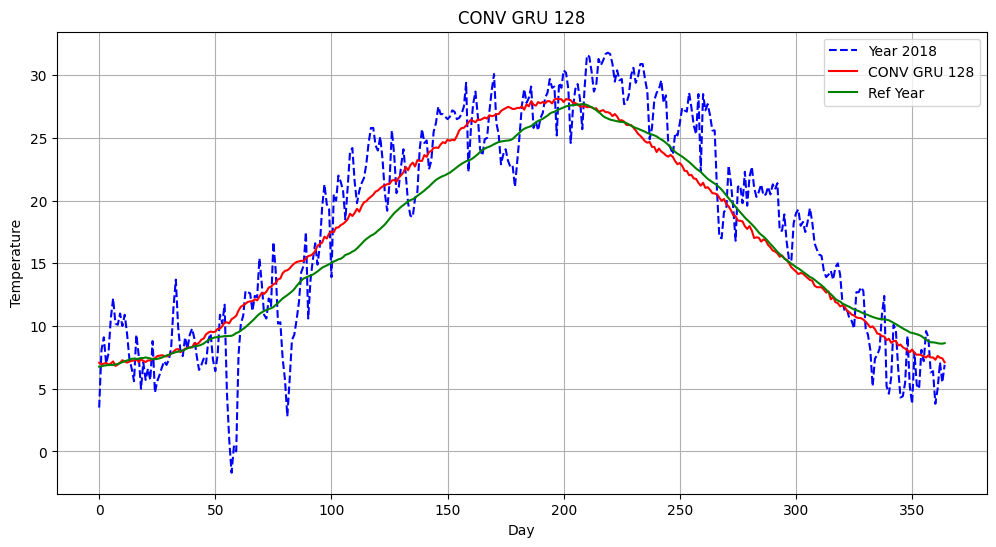

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_128, label="CONV GRU 128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

conv_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_gru_3232 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/60


2025-03-10 23:38:15.373979: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 318.1718 - mae: 15.7251 - val_loss: 248.4610 - val_mae: 13.3399
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 197.8131 - mae: 11.6678 - val_loss: 166.7247 - val_mae: 10.5105
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 131.1678 - mae: 9.2176 - val_loss: 121.9287 - val_mae: 8.8731
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 96.5572 - mae: 7.9929 - val_loss: 99.2688 - val_mae: 8.0747
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 80.5225 - mae: 7.4480 - val_loss: 89.1659 - val_mae: 7.7823
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 73.9030 - mae: 7.2435 - val_loss: 84.9482 - val_mae: 7.6584
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 71.7463 - mae: 7.1923 - val_loss: 83.2499 - val_mae: 7.6083
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 71.0235 - mae: 7.1779 - val_loss: 82.7235 - val_mae: 7.5923
Epoch 9/60
137/137 ━━━━━━━━━━━━━━

In [8]:
conv_gru_3232 = tf.keras.models.load_model('models/conv_gru_3232.keras')
Y_conv_gru_3232 = conv_gru_3232.predict(X)
Y_conv_gru_3232 = Y_conv_gru_3232.flatten()

mae_conv_gru_3232 = mean_absolute_error(Y_test, Y_conv_gru_3232)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_3232}')

rmse_conv_gru_3232 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Mean Absolute Error (MAE): 2.481929576821523
Root Mean Squared Error (RMSE): 3.0750074835041863


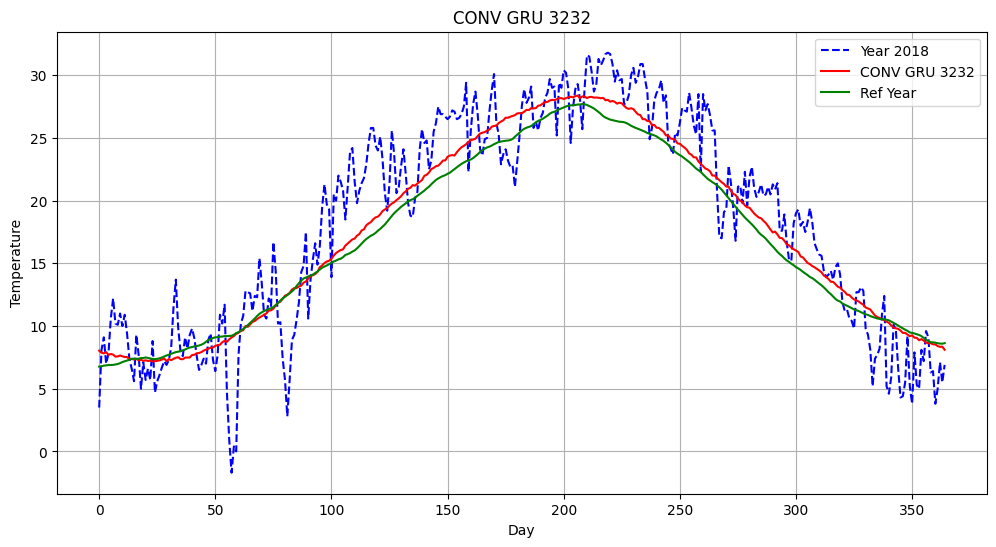

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_3232, label="CONV GRU 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

conv_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_gru_6464 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/50


2025-03-11 00:25:37.485977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 288.0075 - mae: 14.7218 - val_loss: 167.1778 - val_mae: 10.5026
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 121.9316 - mae: 8.8892 - val_loss: 99.7322 - val_mae: 8.0940
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 78.6346 - mae: 7.3899 - val_loss: 85.6925 - val_mae: 7.6873
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 71.5917 - mae: 7.1888 - val_loss: 82.9615 - val_mae: 7.6003
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 70.9582 - mae: 7.1838 - val_loss: 82.8271 - val_mae: 7.6019
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8077 - mae: 7.1809 - val_loss: 82.8470 - val_mae: 7.6043
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.8976 - mae: 7.1873 - val_loss: 82.7427 - val_mae: 7.5994
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 70.8371 - mae: 7.1837 - val_loss: 83.0785 - val_mae: 7.6169
Epoch 9/50
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')
Y_conv_gru_6464 = conv_gru_6464.predict(X)
Y_conv_gru_6464 = Y_conv_gru_6464.flatten()

mae_conv_gru_6464 = mean_absolute_error(Y_test, Y_conv_gru_6464)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_6464}')

rmse_conv_gru_6464 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Mean Absolute Error (MAE): 2.595785836781541
Root Mean Squared Error (RMSE): 3.304525490438252


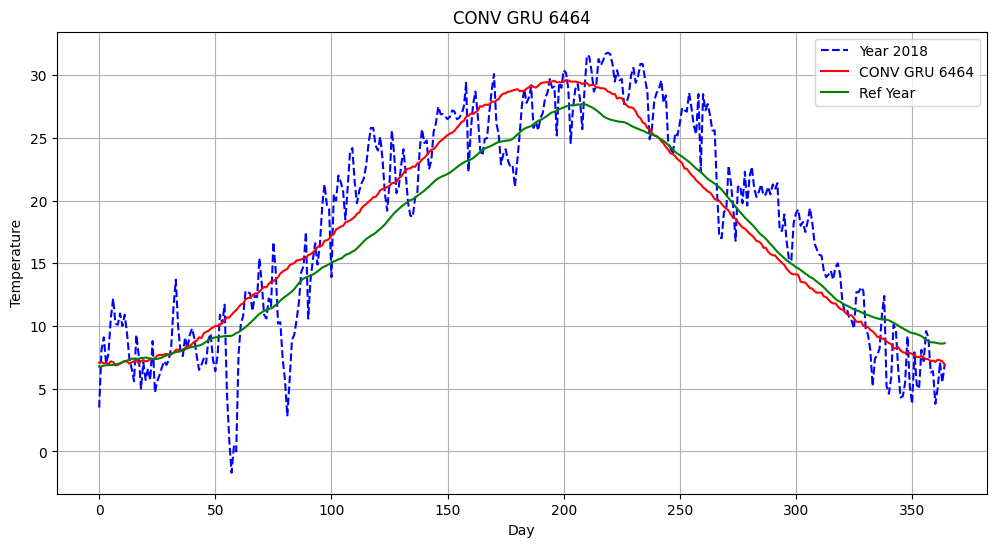

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_6464, label="CONV GRU 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

conv_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_gru_128128 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=45)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/45


2025-03-11 00:48:20.824602: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 242.8033 - mae: 13.1508 - val_loss: 97.9294 - val_mae: 8.0723
Epoch 2/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 75.5266 - mae: 7.3002 - val_loss: 83.4913 - val_mae: 7.6318
Epoch 3/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8973 - mae: 7.1853 - val_loss: 84.2302 - val_mae: 7.6730
Epoch 4/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9094 - mae: 7.1869 - val_loss: 83.7636 - val_mae: 7.6506
Epoch 5/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.9596 - mae: 7.1894 - val_loss: 84.3594 - val_mae: 7.6782
Epoch 6/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.6522 - mae: 7.1703 - val_loss: 79.8884 - val_mae: 7.4470
Epoch 7/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 65.4423 - mae: 6.8704 - val_loss: 53.7597 - val_mae: 5.9826
Epoch 8/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 53.6705 - mae: 6.1620 - val_loss: 36.8088 - val_mae: 4.8292
Epoch 9/45
137/137 ━━━━━━━━━━━━━━━━━━━━ 4

In [8]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')
Y_conv_gru_128128 = conv_gru_128128.predict(X)
Y_conv_gru_128128 = Y_conv_gru_128128.flatten()

mae_conv_gru_128128 = mean_absolute_error(Y_test, Y_conv_gru_128128)
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128128}')

rmse_conv_gru_128128 = np.sqrt(mean_squared_error(Y_test, Y_conv_gru_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
Mean Absolute Error (MAE): 2.599547963077075
Root Mean Squared Error (RMSE): 3.298708213465126


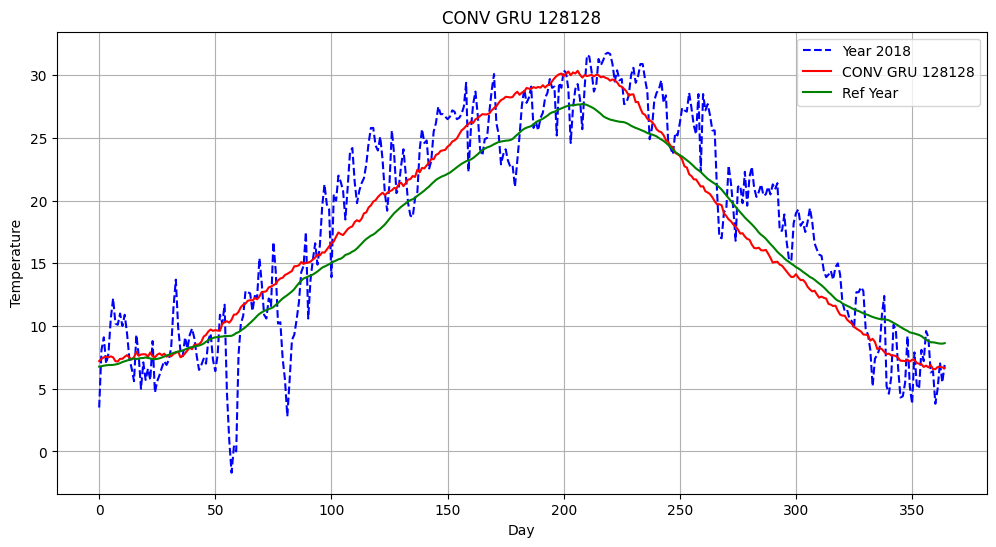

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_gru_128128, label="CONV GRU 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365)
])

conv_lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_3232 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/60


2025-03-11 23:57:43.136234: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 317.4701 - mae: 15.7018 - val_loss: 245.9373 - val_mae: 13.2320
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 195.1816 - mae: 11.5719 - val_loss: 164.7238 - val_mae: 10.4204
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 129.2259 - mae: 9.1471 - val_loss: 120.7065 - val_mae: 8.8329
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 95.3983 - mae: 7.9531 - val_loss: 98.6569 - val_mae: 8.0751
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 79.9452 - mae: 7.4295 - val_loss: 88.9221 - val_mae: 7.7875
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 73.6629 - mae: 7.2371 - val_loss: 84.8763 - val_mae: 7.6600
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 71.6615 - mae: 7.1906 - val_loss: 83.2395 - val_mae: 7.6097
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.9990 - mae: 7.1777 - val_loss: 82.7310 - val_mae: 7.5935
Epoch 9/60
137/137 ━━━━━━━━━━━━━━

In [8]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_2 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 52.2077 - mae: 6.0736 - val_loss: 48.0696 - val_mae: 5.6737
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 48.4503 - mae: 5.8381 - val_loss: 42.5250 - val_mae: 5.2922
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 44.6807 - mae: 5.5872 - val_loss: 39.8319 - val_mae: 5.0705
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 41.5604 - mae: 5.3687 - val_loss: 35.8493 - val_mae: 4.7635
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 36.4498 - mae: 4.9958 - val_loss: 31.3496 - val_mae: 4.4178
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 32.1298 - mae: 4.6594 - val_loss: 27.1343 - val_mae: 4.0832
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 28.0703 - mae: 4.3215 - val_loss: 23.0212 - val_mae: 3.7368
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 23.7083 - mae: 3.9419 - val_loss: 20.8664 - val_mae: 3.5496
Epoch 9/20
137/137 ━━━━━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
conv_lstm_gru_3232 = load_model('models/conv_lstm_gru_3232.keras')
history_conv_lstm_gru_3232_3 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 9.6912 - mae: 2.4792 - val_loss: 11.0659 - val_mae: 2.5154
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.6100 - mae: 2.4688 - val_loss: 11.2189 - val_mae: 2.5422
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.5673 - mae: 2.4651 - val_loss: 10.5076 - val_mae: 2.4645
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.5377 - mae: 2.4613 - val_loss: 11.2836 - val_mae: 2.5475
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 9.4946 - mae: 2.4568 - val_loss: 10.1988 - val_mae: 2.4133
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 9.4136 - mae: 2.4451 - val_loss: 10.3928 - val_mae: 2.4469
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.3746 - mae: 2.4403 - val_loss: 10.3663 - val_mae: 2.4386
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.3396 - mae: 2.4359 - val_loss: 11.7513 - val_mae: 2.6002
Epoch 9/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')
Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232.flatten()

mae_conv_lstm_gru_3232 = mean_absolute_error(Y_test, Y_conv_lstm_gru_3232)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_3232}')

rmse_conv_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_gru_3232))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_3232}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Mean Absolute Error (MAE): 2.54652048555139
Root Mean Squared Error (RMSE): 3.1924181446200888


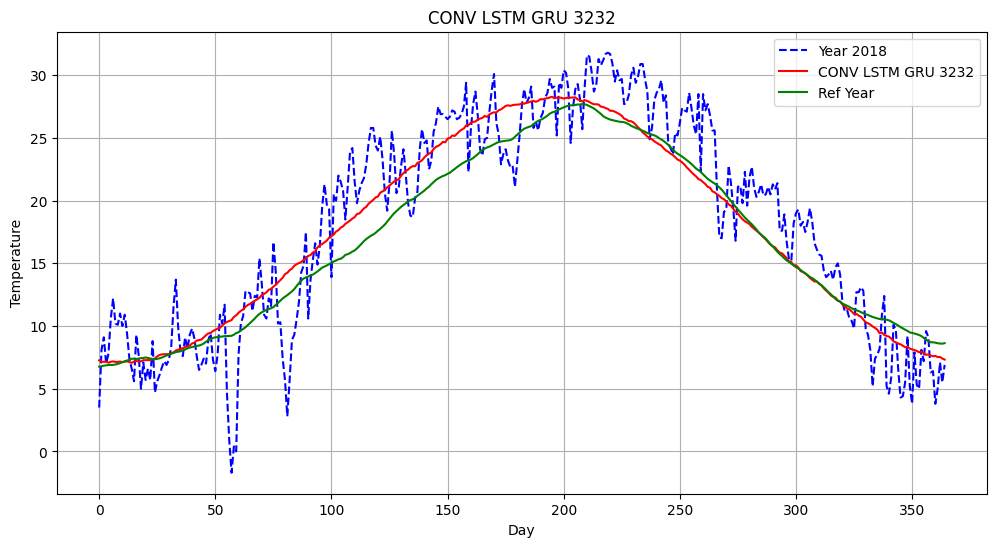

In [12]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_gru_3232, label="CONV LSTM GRU 3232", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365)
])

conv_lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_6464 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/60


2025-03-11 20:23:51.192810: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 288.3941 - mae: 14.7271 - val_loss: 163.4450 - val_mae: 10.3722
Epoch 2/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 118.3378 - mae: 8.7606 - val_loss: 98.4582 - val_mae: 8.0731
Epoch 3/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 77.5391 - mae: 7.3558 - val_loss: 85.5614 - val_mae: 7.6930
Epoch 4/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 71.4327 - mae: 7.1860 - val_loss: 82.9856 - val_mae: 7.6039
Epoch 5/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 70.9474 - mae: 7.1844 - val_loss: 82.8655 - val_mae: 7.6044
Epoch 6/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 70.8088 - mae: 7.1811 - val_loss: 82.8881 - val_mae: 7.6064
Epoch 7/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8989 - mae: 7.1874 - val_loss: 82.7793 - val_mae: 7.6012
Epoch 8/60
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 70.8381 - mae: 7.1838 - val_loss: 83.1305 - val_mae: 7.6194
Epoch 9/60
137/137 ━━━━━━━━━━━━━━━━━━━

In [8]:
conv_lstm_gru_6464 = tf.keras.models.load_model('models/conv_lstm_gru_6464.keras')
Y_conv_lstm_gru_6464 = conv_lstm_gru_6464.predict(X)
Y_conv_lstm_gru_6464 = Y_conv_lstm_gru_6464.flatten()

mae_conv_lstm_gru_6464 = mean_absolute_error(Y_test, Y_conv_lstm_gru_6464)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_6464}')

rmse_conv_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_gru_6464))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_6464}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Mean Absolute Error (MAE): 2.5247614314458144
Root Mean Squared Error (RMSE): 3.255936939975978


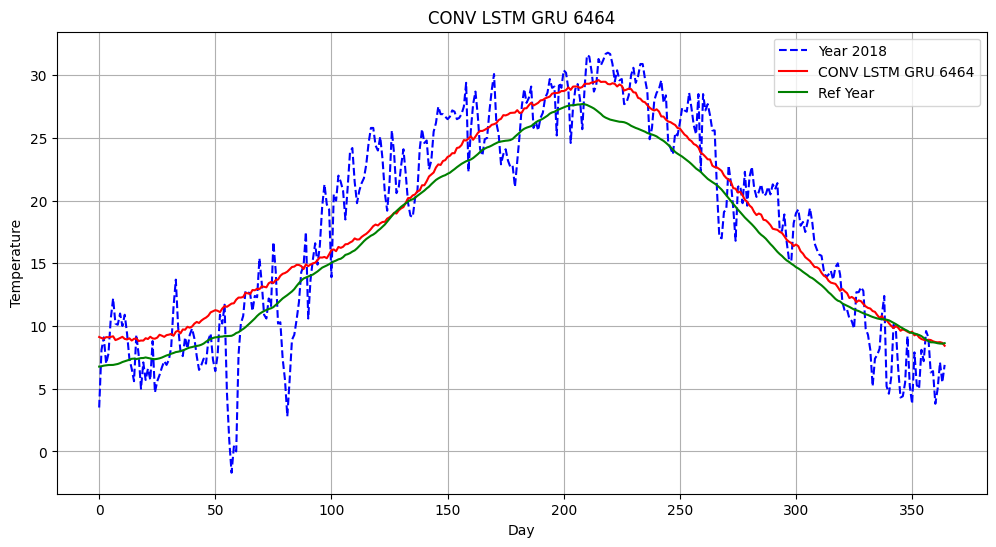

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_gru_6464, label="CONV LSTM GRU 6464", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
conv_lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365)
])

conv_lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_128128 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/40


2025-03-11 21:46:16.276645: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 243.1126 - mae: 13.1558 - val_loss: 96.6788 - val_mae: 8.0098
Epoch 2/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 75.1140 - mae: 7.2884 - val_loss: 83.4575 - val_mae: 7.6307
Epoch 3/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 70.8946 - mae: 7.1856 - val_loss: 84.2741 - val_mae: 7.6756
Epoch 4/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.9101 - mae: 7.1869 - val_loss: 83.8010 - val_mae: 7.6528
Epoch 5/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.9607 - mae: 7.1895 - val_loss: 84.3114 - val_mae: 7.6781
Epoch 6/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.8572 - mae: 7.1840 - val_loss: 84.2699 - val_mae: 7.6762
Epoch 7/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 70.9402 - mae: 7.1893 - val_loss: 84.0209 - val_mae: 7.6640
Epoch 8/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 70.8718 - mae: 7.1850 - val_loss: 85.1967 - val_mae: 7.7239
Epoch 9/40
137/137 ━━━━━━━━━━━━━━━━━━━━ 4

In [8]:
conv_lstm_gru_128128 = tf.keras.models.load_model('models/conv_lstm_gru_128128.keras')
Y_conv_lstm_gru_128128 = conv_lstm_gru_128128.predict(X)
Y_conv_lstm_gru_128128 = Y_conv_lstm_gru_128128.flatten()

mae_conv_lstm_gru_128128 = mean_absolute_error(Y_test, Y_conv_lstm_gru_128128)
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_128128}')

rmse_conv_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test, Y_conv_lstm_gru_128128))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_128128}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Mean Absolute Error (MAE): 2.459431493576259
Root Mean Squared Error (RMSE): 3.1136650430592487


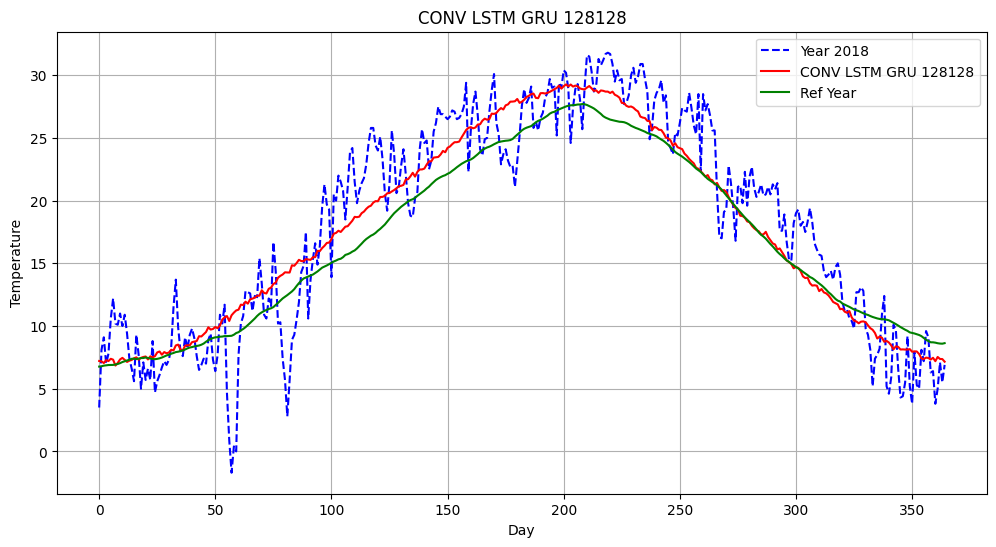

In [9]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test, label="Year 2018", color='blue', linestyle='dashed')
plt.plot(x, Y_conv_lstm_gru_128128, label="CONV LSTM GRU 128128", color='red')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='green')

plt.title("CONV LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 